# Código VAE with diffusion prior - Versão simplificada

## Parte 1: DDPM prior

### a) Timestep embedding
* O objetivo é gerar uma representação contínua dos timesteps (por exemplo, 0, 1, …, T-1), convertendo eles em vetores contínuos por meio de funções trigonométricas (seno e cosseno)

* ***Equações do Positional encoding***:
Para uma posição $pos$ e uma dimensão $i$ do embedding:
$$ 
PE(pos,2i) = sin(\frac{pos}{1000^{2i/d_{model}}})
$$
    
$$ 
PE(pos,2i+1) = cos(\frac{pos}{1000^{2i/d_{model}}}),
$$

onde:
    * $pos$ seria o timestep (ou a posição) que queremos codificar;
    * $d_{model}$ é a dimensão total do embedding;
    * e para cada par de dimensões (uma para o seno e outra para o cosseno), o denominador $1000^{2i/d_{model}}$ garante que cada dimensão do embedding corresponde a uma frequência diferente.
    
* A codificação sinusoidal permite que o modelo saiba a posição (ou, no nosso caso, o timestep) usando funções senoidais e cosenoidais em diferentes frequências.

* Referências:
    * Denoising Diffusion Probabilistic Models (2020)
    * Attention is all you need (2023)

### c) DDPM loss
* Para cada amostra de z0 (latent extraído pelo encoder):
    1. Amostra um timestep t aleatório (de 0 a T-1).
    2. Calcula z_t = sqrt(prod_alpha[t]) * z0 + sqrt(1 - prod_alpha[t]) * epsilon,
         onde epsilon é ruído gaussiano.
    3. O modelo diffusion_prior tenta prever esse epsilon a partir de z_t e t.
    4. A loss é o erro quadrático médio (MSE) entre o ruído previsto e o ruído real.
    
* Equação do artigo:
$$ L_{DDPM} (x_0, \phi) = E_{t,x_0,x_t} [\frac{1}{2 \sigma_t ^2} ||\mu_\phi(x_t,t) - \tilde{\mu}_t(x_0,x_t)||^2],
$$
onde $\tilde{\mu}_t(x_0,x_t)$ é a média de $q(x_{t-1}|x_0,x_t)$, a forward diffusion posterior condicionada na observação $x_0$, $\mu_\phi(x_t,t)$ média prevista pelo modelo para o processo reverso e $\sigma_t ^2$ é a variância associada ao passo t.


* Efetuaremos uma reparametrização para usar o ruído no lugar de $\mu$, ou seja, se parametrizarmos o processo reverso de forma adequada, essa diferença entre as médias pode ser reescrita como a diferença entre o ruído real $\epsilon$ e uma predição do modelo: $||\mu_\phi(x_t,t) - \tilde{\mu}_t(x_0,x_t)||^2 \propto ||\epsilon_\phi(x_t,t) - \epsilon||^2$, onde $\epsilon_\phi(x_t,t)$ é a predição do ruído pelo modelo.
    * A reparametrização usada é $z_t = \sqrt{\Pi_{s=0} ^t \alpha_s}z_0 + \sqrt{1-\Pi_{s=0} ^t \alpha_s} \epsilon$, onde $z_0$ é a amostra do espaço latente (obtida do encoder), $\alpha_s = 1 - \beta_s$ (note que $\alpha_s$ representa a proporção da informação original que permanece após a adição de ruído naquele passo) e $\epsilon$ é amostrado de $N(0,I)$.
    * Tal formulação permite que a amostragem seja diferenciável.
    * Dessa forma, ao treinar o modelo para prever o ruído $\epsilon$ (por meio do MSE), garantimos que a aprendizagem está focada em como remover o ruído do estado atual $z_t$.
    
    
## Parte 2: VAE

### a) Encoder
* Responsável por levar os dados até o espaço latente.
* Usaremos duas redes convolucionais e calcularemos, usando camadas lineares, $\mu$ e $log \sigma^2$ da distribuição $q(z|x)$
* As duas saídas serão usadas para a reparametrização, onde amostramos $z$ a partir de $q(z|x)$.


### b) Decoder
* Responsável por levar do espaço latente até a reconstrução de imagens $(\hat{x})$.
* Primeiro, o vetor $z$ é transformado por uma camada linear e, em seguida, é desachatado.
* Usaremos duas redes convolucionais e usamos a função de ativação sigmoid de modo a garantir uma saída no intervalo [0,1], assim como estão as imagens normalizadas. 


### c) Reparametrização
* Usamos a equação $z = \mu(x) + \sigma(x) \odot \epsilon$, ou seja, $z_i = \mu_i + \sigma_i . \epsilon_i$

## Parte 3: Loss treinamento
* No artigo principal, a loss é dada por:
$$ \mathcal{L}(x;\phi, \theta, \psi) = E_{q_\psi}[log \frac{p_\theta(x|z)}{q_\psi (z|x)}] + E_{q_\psi} [L_{DDPM}(z_0;\phi)],
$$
onde $q_\psi(z|x)$ é a distribuição aproximada do encoder, $p_\theta (x|z)$ é o modelo de verossimilhança do decoder.

* De certo modo, a loss é escrita da forma: $Loss = reconstructed_{Loss} + Latent_{Loss}$.
    * A ***recon_loss*** é calculada como a Binary Cross-Entropy entre a imagem reconstruída e a imagem original.
    * A ***latent_loss***  é calculada a partir da loss de difusão. Essa parte substitui o termo tradicional da KL divergence.
    
* Lembrando que a função loss de difusão faz:
    1. A partir de $z_0$, é gerado o $z_t$ usando o forward do DDPM: $z_t = \sqrt{\Pi_{s=0} ^t \alpha_s}z_0 + \sqrt{1-\Pi_{s=0} ^t \alpha_s} \epsilon$, com $\epsilon \sim N(0,I)$.
    2. O diffusion prior $(\epsilon_\phi(z_t,t))$ tenta prever o ruído $\epsilon$.
    3. A loss é o erro quadrático médio (MSE) entre a predição do ruído e o ruído real: $DDPM_{loss} = ||\epsilon_\phi(z_t,t) - \epsilon||^2$
    
# Por que simplificada?
* Pouco uso da estrutura DCGAN
    * Redes mais simples sem Batch Normalization e poucas camadas
* Betas fixos e lineares
* Função de ativação padrão no prior DDPM
* recon_loss com entropia cruzada

Files already downloaded and verified
Files already downloaded and verified
CIFAR10 Epoch [1/10] Batch 0/391 - Loss: 2140.1787
CIFAR10 Epoch [1/10] Batch 100/391 - Loss: 1855.2354
CIFAR10 Epoch [1/10] Batch 200/391 - Loss: 1816.8862
CIFAR10 Epoch [1/10] Batch 300/391 - Loss: 1763.9988
CIFAR10 Epoch [1/10] Average Loss: 1859.4790
CIFAR10 Epoch [2/10] Batch 0/391 - Loss: 1797.8184
CIFAR10 Epoch [2/10] Batch 100/391 - Loss: 1787.1100
CIFAR10 Epoch [2/10] Batch 200/391 - Loss: 1769.1481
CIFAR10 Epoch [2/10] Batch 300/391 - Loss: 1780.6917
CIFAR10 Epoch [2/10] Average Loss: 1786.5593
CIFAR10 Epoch [3/10] Batch 0/391 - Loss: 1793.1738
CIFAR10 Epoch [3/10] Batch 100/391 - Loss: 1772.7004
CIFAR10 Epoch [3/10] Batch 200/391 - Loss: 1814.1710
CIFAR10 Epoch [3/10] Batch 300/391 - Loss: 1787.8431
CIFAR10 Epoch [3/10] Average Loss: 1781.6539
CIFAR10 Epoch [4/10] Batch 0/391 - Loss: 1789.6901
CIFAR10 Epoch [4/10] Batch 100/391 - Loss: 1769.7175
CIFAR10 Epoch [4/10] Batch 200/391 - Loss: 1723.2361
CI

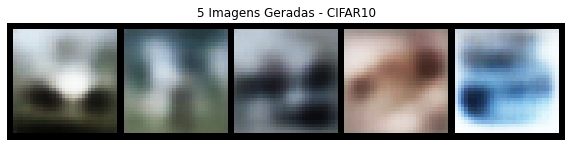

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.77s/it]


CIFAR10 FID: 260.92128114742394


In [11]:
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Parâmetros
hidden_dim = 128         # Dimensão oculta para o diffusion prior
time_embed_dim = 64      # Dimensão do embedding do timestep
latent_dim = 32          # Dimensão do espaço latente
T = 100                  # Número de passos de difusão
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Beta Schedule Linear (DDPM) 
def beta_schedule(T, start=1e-4, end=2e-2):
    return torch.linspace(start, end, T)

betas = beta_schedule(T).to(device)        
alphas = 1 - betas                          
alpha_bars = torch.cumprod(alphas, dim=0)    


# Função de Timestep Embedding (Sinusoidal) 
def timestep_embedding(timesteps, embedding_dim):
    half_dim = embedding_dim // 2 
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) *
                    -(math.log(10000.0) / (half_dim - 1)))
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)  
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros(timesteps.size(0), 1, device=emb.device)], dim=1)
    return emb


# Modelo Diffusion Prior (DDPM) 
class DiffusionPrior(nn.Module):
    def __init__(self, latent_dim, time_embed_dim=time_embed_dim, hidden_dim=hidden_dim):
        super(DiffusionPrior, self).__init__()
        self.fc1 = nn.Linear(latent_dim + time_embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, z_t, t):
        t_embed_dim = self.fc1.in_features - z_t.size(1)
        t_embed = timestep_embedding(t, t_embed_dim)
        x = torch.cat([z_t, t_embed], dim=1)
        x = F.relu(self.fc1(x))
        noise_pred = self.fc2(x)
        return noise_pred

def ddpm_loss(diffusion_prior, z0, betas, alpha_bars, T):
    batch_size, latent_dim = z0.shape
    device = z0.device
    t = torch.randint(0, T, (batch_size,), device=device)
    alpha_bar_t = alpha_bars[t].view(-1, 1)
    epsilon = torch.randn_like(z0)
    z_t = torch.sqrt(alpha_bar_t) * z0 + torch.sqrt(1 - alpha_bar_t) * epsilon
    noise_pred = diffusion_prior(z_t, t)
    loss = F.mse_loss(noise_pred, epsilon)
    return loss


# VAE para CIFAR10 
class EncoderCIFAR10(nn.Module):
    def __init__(self, latent_dim):
        super(EncoderCIFAR10, self).__init__()
        # Entrada: 3x32x32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)   # -> 32x16x16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # -> 64x8x8
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.conv1(x))   # [B,32,16,16]
        x = F.relu(self.conv2(x))   # [B,64,8,8]
        x = x.view(batch_size, -1)  # Flatten para [B, 64*8*8]
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class DecoderCIFAR10(nn.Module):
    def __init__(self, latent_dim):
        super(DecoderCIFAR10, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # -> 32x16x16
        self.deconv2 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)   # -> 3x32x32
    
    def forward(self, z):
        batch_size = z.size(0)
        x = self.fc(z)
        x = x.view(batch_size, 64, 8, 8)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


# Função de Sampling (Reverse Diffusion)
def sample_latent(diffusion_prior, T, latent_dim, betas, alpha_bars, device):
    z = torch.randn((1, latent_dim), device=device)
    for t in reversed(range(1, T)):
        t_tensor = torch.full((z.shape[0],), t, device=device, dtype=torch.long)
        pred_noise = diffusion_prior(z, t_tensor)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        z = (z - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * pred_noise) / torch.sqrt(alpha_t)
        if t > 0:
            noise = torch.randn_like(z)
            z = z + torch.sqrt(beta_t) * noise
    return z


# Inicialização dos Modelos (CIFAR10)
encoder = EncoderCIFAR10(latent_dim).to(device)
decoder = DecoderCIFAR10(latent_dim).to(device)
diffusion_prior = DiffusionPrior(latent_dim, time_embed_dim=time_embed_dim, hidden_dim=hidden_dim).to(device)

optimizer = optim.Adam(list(encoder.parameters()) +
                       list(decoder.parameters()) +
                       list(diffusion_prior.parameters()), lr=5e-4)

# Dataset
transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    
])
train_dataset = datasets.CIFAR10(root='./data CIFAR', train=True, download=True, transform=transform_cifar10)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = datasets.CIFAR10(root='./data CIFAR', train=False, download=True, transform=transform_cifar10)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Salvando algumas imagens reais (ex: 500 imagens do conjunto de teste) para FID
real_folder = './real_images_cifar10'
os.makedirs(real_folder, exist_ok=True)
count = 0
for imgs, _ in test_loader:
    for img in imgs:
        utils.save_image(img, os.path.join(real_folder, f"real_{count}.png"))
        count += 1
        if count >= 500:
            break
    if count >= 500:
        break


# Treinamento (CIFAR10)
num_epochs = 10
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    diffusion_prior.train()
    
    total_loss = 0.0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        
        mu, logvar = encoder(x)
        z0 = reparameterize(mu, logvar)
        
        x_recon = decoder(z0)
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)
        
        latent_loss = ddpm_loss(diffusion_prior, z0, betas, alpha_bars, T)
        
        loss = recon_loss + latent_loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"CIFAR10 Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")
    
    print(f"CIFAR10 Epoch [{epoch+1}/{num_epochs}] Average Loss: {total_loss/len(train_loader):.4f}")


# Resultados: Gerar Imagens e Calcular FID (CIFAR10)
def generate_random_images(diffusion_prior, decoder, num_images, T, latent_dim, betas, alpha_bars, device):
    images = []
    for _ in range(num_images):
        z = sample_latent(diffusion_prior, T, latent_dim, betas, alpha_bars, device)
        img = decoder(z)
        images.append(img)
    images = torch.cat(images, dim=0)
    return images

num_img = 5
diffusion_prior.eval()
decoder.eval()
with torch.no_grad():
    imgs = generate_random_images(diffusion_prior, decoder, num_img, T, latent_dim, betas, alpha_bars, device)
imgs = imgs.cpu()
grid_img = utils.make_grid(imgs, nrow=5)
plt.figure(figsize=(10,5))
plt.imshow(grid_img.permute(1, 2, 0).squeeze())
plt.axis('off')
plt.title("5 Imagens Geradas - CIFAR10")
plt.show()

# Gerar imagens fake para FID (por exemplo, 500 imagens)
fake_folder = './fake_images_cifar10'
os.makedirs(fake_folder, exist_ok=True)
num_generated = 500
generated_images = []
with torch.no_grad():
    for _ in range(num_generated):
        z = sample_latent(diffusion_prior, T, latent_dim, betas, alpha_bars, device)
        img = decoder(z)
        generated_images.append(img)
generated_images = torch.cat(generated_images, dim=0)
def save_images(images, folder, prefix):
    os.makedirs(folder, exist_ok=True)
    for i, img in enumerate(images):
        utils.save_image(img, os.path.join(folder, f"{prefix}_{i}.png"))
save_images(generated_images, fake_folder, 'fake')
from pytorch_fid.fid_score import calculate_fid_given_paths
real_path = real_folder
fake_path = fake_folder
fid_value = calculate_fid_given_paths([real_path, fake_path], batch_size=50, device=device, dims=2048)
print(f"CIFAR10 FID: {fid_value}")
